<a href="https://colab.research.google.com/github/myespindola/dont-patronize-me/blob/main/ProyectoPLN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Procesamiento del Lenguaje Natural
## Don't Patronize Me!

### Integrantes:

- Flores Tiburcio Luis Fernando 
- Vázquez Rojas José David
- Yáñez Espíndola José Marcos


## ¿Qué es PCL?

Alguien es Condescendiente y Despectivo cuando su lenguaje denota una actitud superior hacia los demás, les habla mal o los describe a ellos oa su situación de una manera caritativa, lo que genera un sentimiento de lástima y compasión.

El Lenguaje Condescendiente y Despectivo (PCL, por sus siglas en inglés) es a menudo involuntario e inconsciente. Por otro lado, debido a su sutileza, subjetividad y las (generalmente) buenas intenciones detrás de su uso, la audiencia a menudo desconoce este trato decreciente. Pero el PCL puede ser potencialmente muy dañino, ya que alimenta estereotipos, rutiniza la discriminación y conduce a una mayor exclusión.

La detección de PCL es difícil tanto para los humanos como para los sistemas de PNL, debido a su naturaleza sutil, su subjetividad y la gran cantidad de conocimiento del mundo y razonamiento de sentido común que se requiere para comprender este tipo de lenguaje. Con esta tarea, esperamos ampliar los límites de este nuevo desafío en la comunidad de PNL.

## Objetivos


Clasificación binaria.
Dado un párrafo, procesar los corpues y entrenar un modelo para predecir si contiene o no alguna forma de PCL.

## Configuracion del entorno

In [ ]:
import random
import os
from urllib import request
import nltk
import string 
import re
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from keras.backend import clear_session
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential
from keras import layers
from keras import backend as K
nltk.download('stopwords')
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize  
from collections import Counter
from itertools import chain
import random
from tensorflow.random import set_seed
import plotly.express as px

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
SEED = 68710241

os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
set_seed(SEED)
random.seed(SEED)

## Obtencion de los datos

Los organizadores del concurso nos proporcionaron los siguientes scripts en el repositorio https://github.com/Perez-AlmendrosC/dontpatronizeme: 

- dont_patronize_me.py: contiene funciones para cargar los data sets de training y testing
- evaluation.py: contiene funciones para evaluar nuestro modelo y reportar algunas metricas como el accuracy, precision, recall y el f1 para la primera tarea y el f1 score para cada una de las clases en la segunda tarea


In [ ]:
from dont_patronize_me import DontPatronizeMe
dpm = DontPatronizeMe('.', 'dontpatronizeme_pcl.tsv')

In [ ]:
dpm.load_task1()
task_1_train = dpm.train_task1_df
task_1_train.head()

,par_id,art_id,keyword,country,text,label,orig_label
0,1,@@24942188,hopeless,ph,"we 're living in times of absolute insanity , ...",0,0
1,2,@@21968160,migrant,gh,"in libya today , there are countless number of...",0,0
2,3,@@16584954,immigrant,ie,"""white house press secretary sean spicer said ...",0,0
3,4,@@7811231,disabled,nz,council customers only signs would be displaye...,0,0
4,5,@@1494111,refugee,ca,""""""" just like we received migrants fleeing el ...",0,0


## Limpieza y Preprocesamiento

Observamos que la base viene demasiado sucia en cuanto al texto, por lo que para la limpieza identificamos las siguientes tareas: 

- Eliminar comillas
- Eliminar caracteres no alfanumericos y signos de puntuacion
- Tokenizar


In [ ]:
task_1_train["text"]

0        we 're living in times of absolute insanity , ...
1        in libya today , there are countless number of...
2        "white house press secretary sean spicer said ...
3        council customers only signs would be displaye...
4        """ just like we received migrants fleeing el ...
                               ...                        
10464    "sri lankan norms and culture inhibit women fr...
10465    he added that the afp will continue to bank on...
10466    """ she has one huge platform , and informatio...
10467    """ anja ringgren loven i ca n't find a word t...
10468    """ guinness world record of 540lbs of 7-layer...
Name: text, Length: 10469, dtype: object

In [ ]:
task_1_train["text"] = task_1_train["text"].str.lower()
task_1_train["text"] = task_1_train["text"].str.replace("[^\w ]","")
task_1_train["text"] = task_1_train["text"].str.replace("\s"," ")
task_1_train["text"] = task_1_train["text"].str.strip()
stop_words = stopwords.words('english')
task_1_train['text'] = task_1_train['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
tokenized_doc = task_1_train['text'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
detokenized_doc = []
for i in range(len(task_1_train)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)
task_1_train['text'] = detokenized_doc

## Analisis Exploratorio

In [ ]:
conteo=task_1_train['label'].value_counts()
conteo.index=['lenguaje no condescendiente','lenguaje condescendiente']
px.bar(x=conteo.index,y=conteo,
       title='Numero de textos con lenguaje condescendiente y no condescendiente',
       labels={'y':'Numero de textos','x':'Etiqueta'}
       )

In [ ]:
conteo=task_1_train['country'].value_counts()
px.bar(x=conteo.index,y=conteo,
       title='Numero de textos por pais',
       labels={'y':'Numero de textos','x':'Pais'}
       )

In [ ]:
conteo=task_1_train['keyword'].value_counts()
px.bar(x=conteo.index,y=conteo,
       title='Numero de textos por keyword',
       labels={'y':'Numero de textos','x':'Keyword'}
       )

In [ ]:
def transform_white_backgroud(png_path):
    picture = Image.open(png_path).convert("RGBA")
    image = Image.new("RGB", picture.size, "WHITE")
    image.paste(picture, (0, 0), picture)
    mask = np.array(image)
    return mask
mask=transform_white_backgroud("/content/mask1.png")   

def generar_wordcloud(w, titulo):
  wc = WordCloud(stopwords=STOPWORDS,
                 background_color="white",
                max_words=1000, 
                random_state=42,mask=mask,width=1600, height=800)
  wc.generate_from_frequencies(w)
  plt.figure(figsize=(25,20),facecolor = 'white', edgecolor='blue')
  plt.title(titulo,fontsize=25)
  plt.imshow(wc, interpolation="bilinear")
  plt.axis('off')
  plt.show()

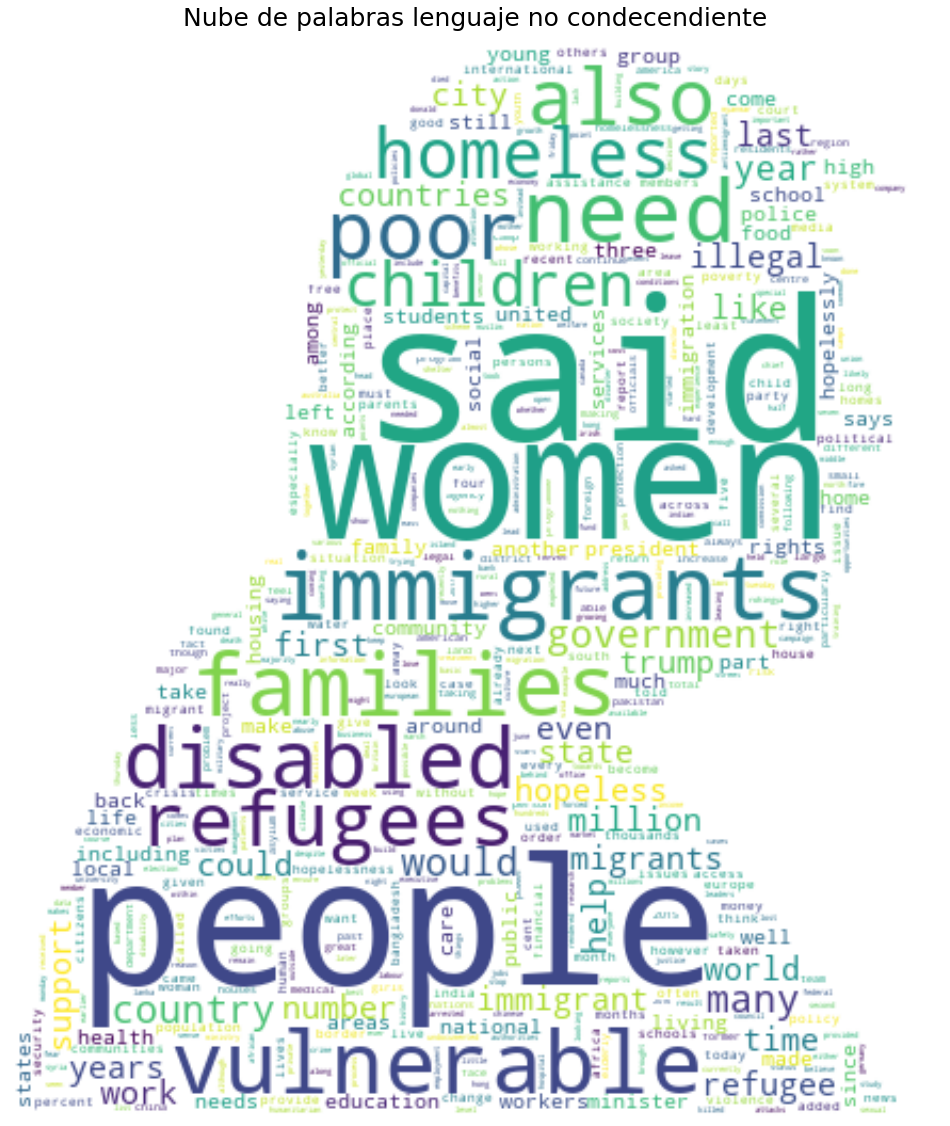

In [ ]:
corpus_stp_no_patronizing=task_1_train['text'] [task_1_train['text'] .index.isin(task_1_train[task_1_train['label']==0].index)]
counter = Counter(chain.from_iterable(map(str.split, corpus_stp_no_patronizing.tolist())))
word_count = pd.Series(counter).sort_values(ascending=False)
generar_wordcloud(word_count,'Nube de palabras lenguaje no condecendiente')

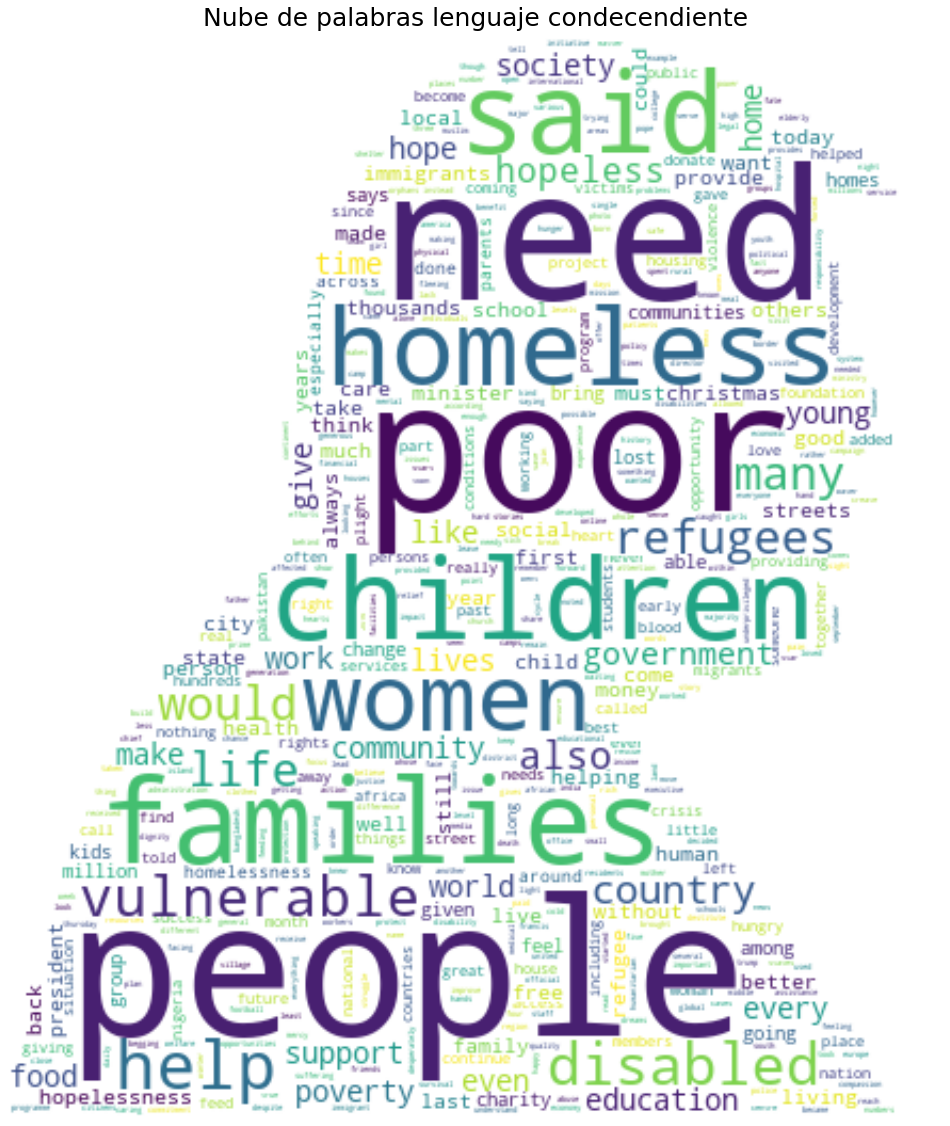

In [ ]:
corpus_stp_patronizing=task_1_train['text'] [task_1_train['text'] .index.isin(task_1_train[task_1_train['label']==1].index)]
counter = Counter(chain.from_iterable(map(str.split, corpus_stp_patronizing.tolist())))
word_count = pd.Series(counter).sort_values(ascending=False)
generar_wordcloud(word_count,'Nube de palabras lenguaje condecendiente')

In [ ]:
def make_ngram(lista,n=2):
  gramas=[]
  for i in range (len(lista)-n+1):
    ngrama=lista[i:i+n]
    gramas.append(" ".join(ngrama))
  return gramas 
bigrams = task_1_train['text'].str.split(" ").apply(make_ngram, n=2)
bigrams_count = np.array(Counter(list(chain.from_iterable(bigrams))).most_common(50))
px.bar(x=bigrams_count[:,0],y=bigrams_count[:,1].astype(int),
       title='Bigramas más frecuentes',
       labels={'y':'Frecuencia','x':'Bigrama'}
       )

In [ ]:
bigrams = corpus_stp_no_patronizing.str.split(" ").apply(make_ngram, n=2)
bigrams_count = np.array(Counter(list(chain.from_iterable(bigrams))).most_common(50))
px.bar(x=bigrams_count[:,0],y=bigrams_count[:,1].astype(int),
       title='Bigramas más frecuentes lenguaje no condecendiente',
       labels={'y':'Frecuencia','x':'Bigrama'}
       )

In [ ]:
bigrams = corpus_stp_patronizing.str.split(" ").apply(make_ngram, n=2)
bigrams_count = np.array(Counter(list(chain.from_iterable(bigrams))).most_common(50))
px.bar(x=bigrams_count[:,0],y=bigrams_count[:,1].astype(int),
       title='Bigramas más frecuentes lenguaje condecendiente',
       labels={'y':'Frecuencia','x':'Bigrama'}
       )

In [ ]:
trigrams = task_1_train['text'].str.split(" ").apply(make_ngram, n=3)
trigrams_count = np.array(Counter(list(chain.from_iterable(trigrams))).most_common(50))
px.bar(x=trigrams_count[:,0],y=trigrams_count[:,1].astype(int),
       title='Trigramas más frecuentes',
       labels={'y':'Frecuencia','x':'Trigrama'}
       )

In [ ]:
trigrams = corpus_stp_no_patronizing.str.split(" ").apply(make_ngram, n=3)
trigrams_count = np.array(Counter(list(chain.from_iterable(trigrams))).most_common(50))
px.bar(x=trigrams_count[:,0],y=trigrams_count[:,1].astype(int),
       title='Trigramas más frecuentes lenguaje no condecendiente',
       labels={'y':'Frecuencia','x':'Trigrama'}
       )

In [ ]:
trigrams = corpus_stp_patronizing.str.split(" ").apply(make_ngram, n=3)
trigrams_count = np.array(Counter(list(chain.from_iterable(trigrams))).most_common(50))
px.bar(x=trigrams_count[:,0],y=trigrams_count[:,1].astype(int),
       title='Trigramas más frecuentes lenguaje condecendiente',
       labels={'y':'Frecuencia','x':'Trigrama'}
       )

## Modelado

Usaremos una red neuronal simple con una capa de entrada, una capa intermedia y una capa de salida para probar cuales son las mejores caracteristicas para obtener el mejor F1 score, probaremos con:

- Bolsa de palabras usando las frecuencias
- Bolsa de palabras usando el TF-IDF
- Bigramas
- Trigramas
- Embeddings

In [ ]:
text = task_1_train["text"].values
y = task_1_train['label'].values
text_train, text_test, y_train, y_test = train_test_split(text, y, test_size=0.25, random_state=SEED)

In [ ]:
v = CountVectorizer(max_features=20000, max_df=0.8)
v.fit(text)

CountVectorizer(max_df=0.8, max_features=20000)

In [ ]:
print('Componentes de primer documento: {0}'.format(text_train[0]))
print('Bolsa de primer documento: [\n{0}]'.format(v.transform(task_1_train["text"])[0]))

Componentes de primer documento: centenarians talk life experiences lessons help keep head also great examples feel hopeless small stuff nothing lasts forever pain temporary
Bolsa de primer documento: [
  (0, 299)	1
  (0, 403)	1
  (0, 1232)	1
  (0, 1425)	1
  (0, 1654)	1
  (0, 1679)	2
  (0, 1951)	1
  (0, 2136)	1
  (0, 2165)	1
  (0, 2294)	1
  (0, 2331)	1
  (0, 2933)	1
  (0, 3610)	1
  (0, 4284)	1
  (0, 4840)	1
  (0, 4883)	1
  (0, 5046)	1
  (0, 5183)	1
  (0, 5290)	1
  (0, 5893)	1
  (0, 6076)	1
  (0, 6223)	1
  (0, 6365)	1
  (0, 6556)	1
  (0, 6826)	1
  (0, 6870)	1
  (0, 7795)	1
  (0, 7840)	2
  (0, 8012)	1
  (0, 8800)	1
  (0, 8905)	1
  (0, 9336)	1
  (0, 9519)	1
  (0, 9906)	2
  (0, 10040)	1
  (0, 10918)	1
  (0, 11023)	1
  (0, 13942)	1
  (0, 13945)	1
  (0, 14987)	1
  (0, 15653)	1
  (0, 16253)	1
  (0, 17008)	1
  (0, 17093)	1
  (0, 17149)	1
  (0, 17690)	1
  (0, 19016)	1
  (0, 19358)	1
  (0, 19517)	1]


In [ ]:
X_train = v.transform(text_train)
X_test  = v.transform(text_test)

In [ ]:
input_dim = X_train.shape[1]

model_frec = Sequential()
model_frec.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model_frec.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.sparse.reorder(tf.SparseTensor(indices, coo.data, coo.shape))

In [ ]:
model_frec.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=[f1_m])
model_frec.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                200010    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 200,021
Trainable params: 200,021
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model_frec.fit(convert_sparse_matrix_to_sparse_tensor(X_train), y_train,
                     epochs=50,
                     verbose=1,
                     batch_size=10,
                     )

Epoch 1/50
786/786 [==============================] - 8s 8ms/step - loss: 0.3521 - f1_m: 0.0013
Epoch 2/50
786/786 [==============================] - 7s 9ms/step - loss: 0.2094 - f1_m: 0.0405
Epoch 3/50
786/786 [==============================] - 6s 8ms/step - loss: 0.1278 - f1_m: 0.3114
Epoch 4/50
786/786 [==============================] - 6s 7ms/step - loss: 0.0690 - f1_m: 0.4651
Epoch 5/50
786/786 [==============================] - 6s 7ms/step - loss: 0.0385 - f1_m: 0.5625
Epoch 6/50
786/786 [==============================] - 6s 7ms/step - loss: 0.0229 - f1_m: 0.6073
Epoch 7/50
786/786 [==============================] - 6s 7ms/step - loss: 0.0151 - f1_m: 0.6124
Epoch 8/50
786/786 [==============================] - 6s 7ms/step - loss: 0.0108 - f1_m: 0.6187
Epoch 9/50
786/786 [==============================] - 6s 7ms/step - loss: 0.0082 - f1_m: 0.6130
Epoch 10/50
786/786 [==============================] - 6s 7ms/step - loss: 0.0063 - f1_m: 0.6120
Epoch 11/50
786/786 [==================

In [ ]:
clear_session()

In [ ]:
loss, f1 = model_frec.evaluate(convert_sparse_matrix_to_sparse_tensor(X_train), y_train, verbose=False)
print("Training F1: {:.4f}".format(f1))
loss, f1 = model_frec.evaluate(convert_sparse_matrix_to_sparse_tensor(X_test), y_test, verbose=False)
print("Testing F1:  {:.4f}".format(f1))

Training F1: 0.9671
Testing F1:  0.2730


In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['f1_m']
    loss = history.history['loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training f1')
    plt.title('Training and validation f1')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.title('Training and validation loss')
    plt.legend()

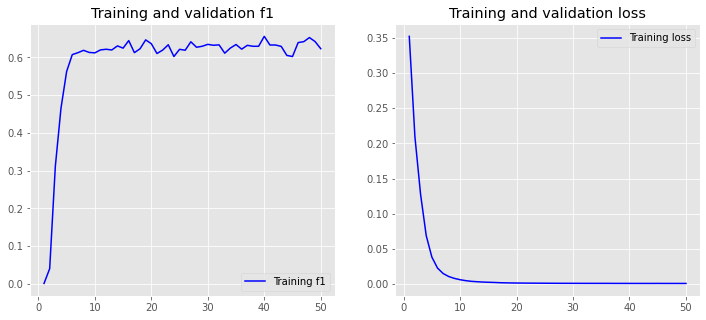

In [ ]:
plot_history(history)

Usando TFIDF

In [ ]:
tfidf = TfidfVectorizer(max_features=20000, max_df=0.8)
tfidf.fit(text)

TfidfVectorizer(max_df=0.8, max_features=20000)

In [ ]:
print('Componentes de primer documento: {0}'.format(text_train[0]))
print('Bolsa de primer documento: [\n{0}]'.format(tfidf.transform(task_1_train["text"])[0]))

Componentes de primer documento: centenarians talk life experiences lessons help keep head also great examples feel hopeless small stuff nothing lasts forever pain temporary
Bolsa de primer documento: [
  (0, 19517)	0.16396653553429097
  (0, 19358)	0.11108297541537242
  (0, 19016)	0.17739353178476625
  (0, 17690)	0.11129468310628209
  (0, 17149)	0.10253925174628423
  (0, 17093)	0.16396653553429097
  (0, 17008)	0.10530084955445951
  (0, 16253)	0.12104852214294867
  (0, 15653)	0.1187278458049348
  (0, 14987)	0.16396653553429097
  (0, 13945)	0.1153005102812921
  (0, 13942)	0.1371125430333404
  (0, 11023)	0.12980395350294652
  (0, 10918)	0.13632177769124149
  (0, 10040)	0.1718208248381426
  (0, 9906)	0.11279963442803499
  (0, 9519)	0.15611224623043937
  (0, 9336)	0.15222504196687453
  (0, 8905)	0.10110370170417843
  (0, 8800)	0.12140396442563718
  (0, 8012)	0.16749829751516732
  (0, 7840)	0.1993003810945812
  (0, 7795)	0.08911225549580895
  (0, 6870)	0.15222504196687453
  (0, 6826)	0.16749

In [ ]:
X_train = tfidf.transform(text_train)
X_test  = tfidf.transform(text_test)

In [ ]:
input_dim = X_train.shape[1]

model_tfidf = Sequential()
model_tfidf.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model_tfidf.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model_tfidf.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=[f1_m])
model_tfidf.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                200010    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 200,021
Trainable params: 200,021
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model_tfidf.fit(convert_sparse_matrix_to_sparse_tensor(X_train), y_train,
                     epochs=50,
                     verbose=1,
                     batch_size=10)

Epoch 1/50
786/786 [==============================] - 7s 7ms/step - loss: 0.3605 - f1_m: 0.0000e+00
Epoch 2/50
786/786 [==============================] - 6s 7ms/step - loss: 0.2499 - f1_m: 0.0000e+00
Epoch 3/50
786/786 [==============================] - 6s 7ms/step - loss: 0.1833 - f1_m: 0.0853
Epoch 4/50
786/786 [==============================] - 6s 7ms/step - loss: 0.1194 - f1_m: 0.3493
Epoch 5/50
786/786 [==============================] - 6s 7ms/step - loss: 0.0742 - f1_m: 0.5112
Epoch 6/50
786/786 [==============================] - 6s 7ms/step - loss: 0.0451 - f1_m: 0.5703
Epoch 7/50
786/786 [==============================] - 6s 7ms/step - loss: 0.0273 - f1_m: 0.6009
Epoch 8/50
786/786 [==============================] - 6s 7ms/step - loss: 0.0165 - f1_m: 0.6157
Epoch 9/50
786/786 [==============================] - 6s 7ms/step - loss: 0.0103 - f1_m: 0.6141
Epoch 10/50
786/786 [==============================] - 6s 7ms/step - loss: 0.0065 - f1_m: 0.6196
Epoch 11/50
786/786 [==========

In [ ]:
clear_session()

In [ ]:
loss, f1 = model_tfidf.evaluate(convert_sparse_matrix_to_sparse_tensor(X_train), y_train, verbose=False)
print("Training F1: {:.4f}".format(f1))
loss, f1 = model_tfidf.evaluate(convert_sparse_matrix_to_sparse_tensor(X_test), y_test, verbose=False)
print("Testing F1:  {:.4f}".format(f1))

Training F1: 0.9675
Testing F1:  0.2750


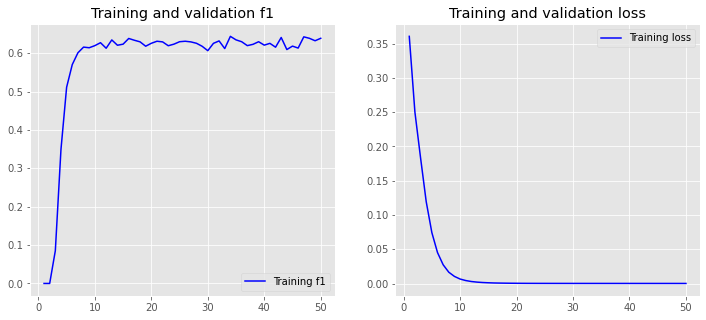

In [ ]:
plot_history(history)

Bigramas

In [ ]:
v_bigramas = CountVectorizer(stop_words='english', max_features=100000, max_df=0.8, ngram_range = (1,2))
v_bigramas.fit(text)

CountVectorizer(max_df=0.8, max_features=100000, ngram_range=(1, 2),
                stop_words='english')

In [ ]:
print('Componentes de primer documento: {0}'.format(text_train[0]))
print('Bolsa de primer documento: [\n{0}]'.format(v_bigramas.transform(task_1_train["text"])[0]))

Componentes de primer documento: centenarians talk life experiences lessons help keep head also great examples feel hopeless small stuff nothing lasts forever pain temporary
Bolsa de primer documento: [
  (0, 438)	1
  (0, 658)	1
  (0, 2027)	1
  (0, 2651)	1
  (0, 2693)	2
  (0, 3122)	1
  (0, 3456)	1
  (0, 3516)	1
  (0, 3758)	1
  (0, 3816)	1
  (0, 4962)	1
  (0, 5960)	1
  (0, 7122)	1
  (0, 8403)	1
  (0, 8907)	1
  (0, 10342)	1
  (0, 10637)	1
  (0, 10981)	1
  (0, 11469)	1
  (0, 11485)	1
  (0, 12122)	1
  (0, 12611)	1
  (0, 12671)	1
  (0, 14370)	1
  (0, 14490)	2
  :	:
  (0, 33832)	1
  (0, 35421)	1
  (0, 35422)	1
  (0, 37949)	2
  (0, 38014)	1
  (0, 38379)	1
  (0, 40049)	1
  (0, 46475)	1
  (0, 46491)	1
  (0, 47287)	1
  (0, 47301)	1
  (0, 70777)	1
  (0, 71868)	1
  (0, 73400)	1
  (0, 73435)	1
  (0, 78764)	1
  (0, 78766)	1
  (0, 79322)	1
  (0, 79326)	1
  (0, 83240)	1
  (0, 83261)	1
  (0, 91069)	1
  (0, 91070)	1
  (0, 94356)	1
  (0, 94361)	1]


In [ ]:
X_train = v_bigramas.transform(text_train)
X_test  = v_bigramas.transform(text_test)

In [ ]:
input_dim = X_train.shape[1]

model_bigramas = Sequential()
model_bigramas.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model_bigramas.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model_bigramas.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=[f1_m])
model_bigramas.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                1000010   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 1,000,021
Trainable params: 1,000,021
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model_bigramas.fit(convert_sparse_matrix_to_sparse_tensor(X_train), y_train,
                     epochs=50,
                     verbose=1,
                     batch_size=10)

Epoch 1/50
786/786 [==============================] - 6s 7ms/step - loss: 0.3296 - f1_m: 0.0000e+00
Epoch 2/50
786/786 [==============================] - 6s 7ms/step - loss: 0.1315 - f1_m: 0.1961
Epoch 3/50
786/786 [==============================] - 6s 7ms/step - loss: 0.0445 - f1_m: 0.5824
Epoch 4/50
786/786 [==============================] - 6s 7ms/step - loss: 0.0146 - f1_m: 0.6219
Epoch 5/50
786/786 [==============================] - 6s 7ms/step - loss: 0.0069 - f1_m: 0.6124
Epoch 6/50
786/786 [==============================] - 6s 7ms/step - loss: 0.0040 - f1_m: 0.6299
Epoch 7/50
786/786 [==============================] - 6s 7ms/step - loss: 0.0027 - f1_m: 0.6304
Epoch 8/50
786/786 [==============================] - 6s 7ms/step - loss: 0.0014 - f1_m: 0.6349
Epoch 9/50
786/786 [==============================] - 6s 7ms/step - loss: 9.0371e-04 - f1_m: 0.6209
Epoch 10/50
786/786 [==============================] - 6s 7ms/step - loss: 6.7806e-04 - f1_m: 0.6298
Epoch 11/50
786/786 [======

In [ ]:
clear_session()

In [ ]:
loss, f1 = model_bigramas.evaluate(convert_sparse_matrix_to_sparse_tensor(X_train), y_train, verbose=False)
print("Training F1: {:.4f}".format(f1))
loss, f1 = model_bigramas.evaluate(convert_sparse_matrix_to_sparse_tensor(X_test), y_test, verbose=False)
print("Testing F1:  {:.4f}".format(f1))

Training F1: 0.9675
Testing F1:  0.2494


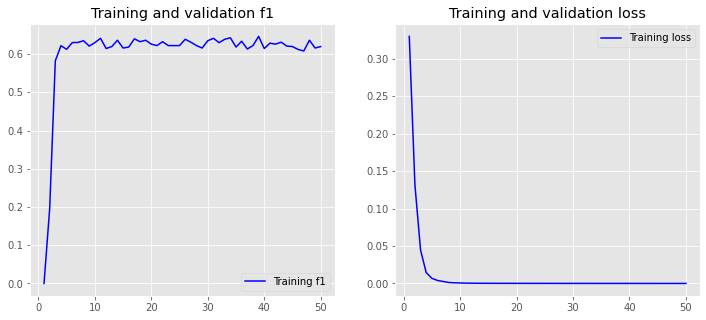

In [ ]:
plot_history(history)

Trigramas

In [ ]:
v_trigramas = CountVectorizer(stop_words='english', max_features=200000, max_df=0.8, ngram_range = (1,3))
v_trigramas.fit(text)

CountVectorizer(max_df=0.8, max_features=200000, ngram_range=(1, 3),
                stop_words='english')

In [ ]:
print('Componentes de primer documento: {0}'.format(text_train[0]))
print('Bolsa de primer documento: [\n{0}]'.format(v_trigramas.transform(task_1_train["text"])[0]))

Componentes de primer documento: centenarians talk life experiences lessons help keep head also great examples feel hopeless small stuff nothing lasts forever pain temporary
Bolsa de primer documento: [
  (0, 477)	1
  (0, 726)	1
  (0, 2201)	1
  (0, 2866)	1
  (0, 2911)	2
  (0, 3378)	1
  (0, 3737)	1
  (0, 3803)	1
  (0, 4060)	1
  (0, 4118)	1
  (0, 5404)	1
  (0, 6480)	1
  (0, 7756)	1
  (0, 9151)	1
  (0, 9723)	1
  (0, 11265)	1
  (0, 11575)	1
  (0, 11955)	1
  (0, 12511)	1
  (0, 12529)	1
  (0, 13295)	1
  (0, 13828)	1
  (0, 13890)	1
  (0, 15759)	1
  (0, 16143)	2
  :	:
  (0, 84470)	1
  (0, 84496)	1
  (0, 84497)	1
  (0, 134421)	1
  (0, 139783)	1
  (0, 139845)	1
  (0, 139846)	1
  (0, 148162)	1
  (0, 148231)	1
  (0, 148233)	1
  (0, 158308)	1
  (0, 158311)	1
  (0, 158312)	1
  (0, 159426)	1
  (0, 159433)	1
  (0, 159434)	1
  (0, 166899)	1
  (0, 166943)	1
  (0, 166944)	1
  (0, 182007)	1
  (0, 182008)	1
  (0, 182009)	1
  (0, 188221)	1
  (0, 188230)	1
  (0, 188231)	1]


In [ ]:
X_train = v_trigramas.transform(text_train)
X_test  = v_trigramas.transform(text_test)

In [ ]:
input_dim = X_train.shape[1]

model_trigramas = Sequential()
model_trigramas.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model_trigramas.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model_trigramas.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=[f1_m])
model_trigramas.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                2000010   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 2,000,021
Trainable params: 2,000,021
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model_trigramas.fit(convert_sparse_matrix_to_sparse_tensor(X_train), y_train,
                     epochs=50,
                     verbose=1,
                     batch_size=10)

Epoch 1/50
786/786 [==============================] - 7s 8ms/step - loss: 0.3530 - f1_m: 4.2409e-04
Epoch 2/50
786/786 [==============================] - 7s 9ms/step - loss: 0.1333 - f1_m: 0.1923
Epoch 3/50
786/786 [==============================] - 6s 8ms/step - loss: 0.0411 - f1_m: 0.5676
Epoch 4/50
786/786 [==============================] - 6s 8ms/step - loss: 0.0127 - f1_m: 0.6073
Epoch 5/50
786/786 [==============================] - 6s 8ms/step - loss: 0.0060 - f1_m: 0.6222
Epoch 6/50
786/786 [==============================] - 6s 8ms/step - loss: 0.0046 - f1_m: 0.6075
Epoch 7/50
786/786 [==============================] - 7s 9ms/step - loss: 0.0021 - f1_m: 0.6420
Epoch 8/50
786/786 [==============================] - 7s 9ms/step - loss: 0.0018 - f1_m: 0.6237
Epoch 9/50
786/786 [==============================] - 6s 8ms/step - loss: 0.0013 - f1_m: 0.6340
Epoch 10/50
786/786 [==============================] - 6s 8ms/step - loss: 8.8005e-04 - f1_m: 0.6192
Epoch 11/50
786/786 [==========

In [ ]:
loss, f1 = model_trigramas.evaluate(convert_sparse_matrix_to_sparse_tensor(X_train), y_train, verbose=False)
print("Training F1: {:.4f}".format(f1))
loss, f1 = model_trigramas.evaluate(convert_sparse_matrix_to_sparse_tensor(X_test), y_test, verbose=False)
print("Testing F1:  {:.4f}".format(f1))

Training F1: 0.9675
Testing F1:  0.2221


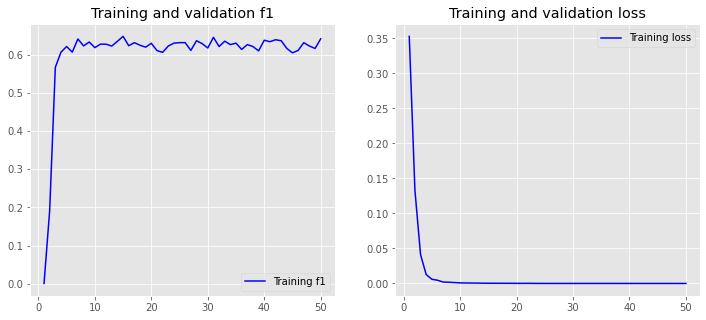

In [ ]:
plot_history(history)

Usando word embeddings

In [ ]:
from keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(text)

X_train = tokenizer.texts_to_sequences(text_train)
X_test = tokenizer.texts_to_sequences(text_test)

vocab_size = len(tokenizer.word_index) + 1

In [ ]:
from keras.preprocessing.sequence import pad_sequences
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
model_embeddings = Sequential()
model_embeddings.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=300, 
                           input_length=maxlen))
model_embeddings.add(layers.Flatten())
model_embeddings.add(layers.Dense(10, activation='relu'))
model_embeddings.add(layers.Dense(1, activation='sigmoid'))
model_embeddings.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[f1_m])
model_embeddings.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          9114300   
_________________________________________________________________
flatten (Flatten)            (None, 30000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                300010    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 9,414,321
Trainable params: 9,414,321
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model_embeddings.fit(X_train, y_train,
                    epochs=50,
                    verbose=1,
                    batch_size=10)


Epoch 1/50
786/786 [==============================] - 7s 8ms/step - loss: 0.2953 - f1_m: 0.0000e+00
Epoch 2/50
786/786 [==============================] - 6s 8ms/step - loss: 0.0983 - f1_m: 0.4549
Epoch 3/50
786/786 [==============================] - 6s 8ms/step - loss: 0.0506 - f1_m: 0.6157
Epoch 4/50
786/786 [==============================] - 6s 8ms/step - loss: 0.0353 - f1_m: 0.6321
Epoch 5/50
786/786 [==============================] - 6s 8ms/step - loss: 0.0256 - f1_m: 0.6310
Epoch 6/50
786/786 [==============================] - 6s 8ms/step - loss: 0.0189 - f1_m: 0.6071
Epoch 7/50
786/786 [==============================] - 6s 8ms/step - loss: 0.0143 - f1_m: 0.6212
Epoch 8/50
786/786 [==============================] - 6s 8ms/step - loss: 0.0110 - f1_m: 0.6052
Epoch 9/50
786/786 [==============================] - 6s 8ms/step - loss: 0.0087 - f1_m: 0.6121
Epoch 10/50
786/786 [==============================] - 6s 8ms/step - loss: 0.0071 - f1_m: 0.6285
Epoch 11/50
786/786 [==============

In [ ]:
loss, f1 = model_embeddings.evaluate(X_train, y_train, verbose=False)
print("Training F1: {:.4f}".format(f1))
loss, f1 = model_embeddings.evaluate(X_test, y_test, verbose=False)
print("Testing F1:  {:.4f}".format(f1))

Training F1: 0.9659
Testing F1:  0.2434


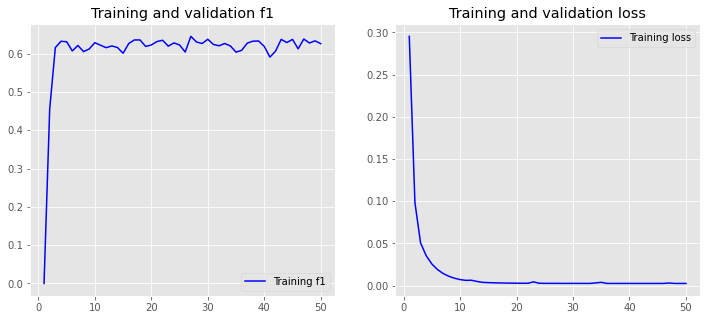

In [ ]:
plot_history(history)

Resultados

In [ ]:
def labels2file(p, outf_path):
	
	with open(outf_path,'w') as outf:
		for p_i in p:
			outf.write(','.join([str(k) for k in p_i])+'\n')

In [ ]:
!mkdir ref res

A subdirectory or file ref already exists.
Error occurred while processing: ref.
A subdirectory or file res already exists.
Error occurred while processing: res.


In [ ]:
X_test  = v.transform(text_test)

In [ ]:
preds_task1 = model_tfidf.predict_classes(X_test)
labels2file(preds_task1, os.path.join('res/', 'task1.txt'))

In [ ]:
labels2file(y_test.reshape((len(y_test),1)), os.path.join('ref/', 'task1.txt'))

In [ ]:
!python evaluation.py . .

In [ ]:
f = open("scores.txt", "r")
print(f.read())

task1_precision:0.25667351129363447
task1_recall:0.49407114624505927
task1_f1:0.33783783783783783

